In [76]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
import torch
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [77]:
from google.colab import drive
from google.colab import files

# 구글 드라이브 마운트
drive.mount('/content/drive')

# 로컬 파일 업로드
uploaded = files.upload()

# 업로드된 파일 이동
for filename in uploaded.keys():
    # 업로드된 파일을 구글 드라이브의 원하는 경로로 이동
    !mv "{filename}" "/content/drive/MyDrive/{filename}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving bs_1.csv to bs_1.csv


In [78]:
df = pd.read_csv('/content/drive/MyDrive/bs_1.csv', encoding='cp949')
df

,연도,월,평균 풍속(m/s),평균기압(hPa),평균 상대습도(%),평균 수온(°C),평균 유의 파고(m),평균 파주기(sec),한국,중국,...,수출환적(TEU),수입물가지수,usd비율(Yuan/US),Dubai국제유가(US/배럴),강수량(mm),평균기온,평균최저기온,평균최고기온,?섏텧(TEU),?섏엯?섏쟻(TEU)
0,2014,1,6.253333,1023.482759,52.133333,14.053333,0.976667,6.336667,1,3,...,389979.75,128.15,6.105,104.0,9.6,5.0,1.2,9.7,353915.75,365515.00
1,2014,2,7.807143,1022.729630,65.392857,13.289286,1.650000,7.264286,1,2,...,350400.25,128.34,6.121,105.0,44.1,5.8,2.7,9.9,334478.00,334191.25
2,2014,3,6.080000,1019.790000,67.133333,13.096667,1.167742,6.425806,1,1,...,383563.50,127.66,6.152,104.4,136.7,9.8,6.2,14.5,405896.25,402860.75
3,2014,4,5.116667,1016.806667,72.866667,14.790000,0.877778,5.877778,0,3,...,401684.25,127.56,6.158,104.6,147.8,14.6,11.2,19.3,391681.50,402606.75
4,2014,5,5.283333,1012.036667,79.266667,16.340000,0.886667,5.896667,2,5,...,388978.25,127.70,6.169,105.6,145.9,18.7,15.4,23.2,396793.75,395188.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,2023,1,7.464516,1014.648387,76.193548,23.861290,1.387097,4.706452,5,9,...,489668.00,123.42,6.753,80.4,79.2,3.8,-0.2,8.9,401093.00,417851.25
109,2023,2,6.096429,1022.039286,63.142857,21.375000,0.892857,4.135714,0,0,...,471788.00,123.78,6.945,82.1,30.0,6.8,2.9,11.8,410600.50,430718.00
110,2023,3,6.461290,1020.825806,62.806452,19.183871,0.996774,4.309677,1,1,...,540680.00,121.61,6.869,78.5,76.2,12.3,8.5,17.0,493589.25,465645.25
111,2023,4,6.862069,1023.131034,55.827586,16.248276,1.100000,4.531034,0,3,...,552678.25,120.72,6.923,83.4,101.6,14.6,11.0,19.0,462679.00,467042.00


In [79]:
x = df.iloc[:,0:-1]
y = df.iloc[:,-1:]

# Training/Test ratio = 7:3
Train_ratio = 0.7
Test_ratio = 0.3

# Data Division
train_x = x.iloc[0:int(len(df)*Train_ratio),:]
train_y = y.iloc[0:int(len(df)*Train_ratio),:]
test_x = x.iloc[int(len(df)*Train_ratio):,:]
test_y = y.iloc[int(len(df)*Train_ratio):,:]

In [80]:
# Normalizing
minmax = MinMaxScaler()

train_x = minmax.fit_transform(train_x)
train_y = minmax.fit_transform(train_y)
test_x = minmax.fit_transform(test_x)
test_y = minmax.fit_transform(test_y)

# Check Data pre-processing
print("Training shape : ", train_x.shape, train_y.shape)
print("Test shape : ",test_x.shape, test_y.shape)

Training shape :  (79, 21) (79, 1)
Test shape :  (34, 21) (34, 1)


In [81]:
train_x_tensor = Variable(torch.Tensor(train_x))
train_y_tensor = Variable(torch.Tensor(train_y))
test_x_tensor = Variable(torch.Tensor(test_x))
test_y_tensor = Variable(torch.Tensor(test_y))

print("After torch variable shape_Train : ",train_x_tensor.shape, train_y.shape)
print("After torch Variable shape_Test : ",test_x_tensor.shape, test_y_tensor.shape)

After torch variable shape_Train :  torch.Size([79, 21]) (79, 1)
After torch Variable shape_Test :  torch.Size([34, 21]) torch.Size([34, 1])


In [82]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, nhead, dropout):
        super(TransformerModel, self).__init__()

        # Multi-Head Self-Attention 레이어
        self.transformer = nn.Transformer(
            d_model=input_size,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size,
            dropout=dropout,
            batch_first=True
        )

        # Fully Connected 레이어
        self.fc = nn.Linear(input_size, 1)  # 예측값은 1개의 값 (다음 시간 단계의 값)

    def forward(self, src, tgt):
        # Transformer 모델을 통한 예측
        x = self.transformer(src, tgt)

        # Fully Connected 레이어를 통한 예측값 생성
        x = self.fc(x[:, -1, :])  # 마지막 시간 단계의 예측값만 사용

        return x

In [83]:
train_x_tensor_final.shape[2]

21

In [84]:
# 하이퍼파라미터 설정
embed_dim = 21  # 임베딩 차원 (64의 배수)
input_size = train_x_tensor_final.shape[2]  # 입력 차원 (특성 수)
hidden_size = 21  # 중간 레이어의 차원
num_layers = 2  # Transformer 레이어 수
nhead = 3  # Multi-Head Attention 헤드 수
dropout = 0.2  # 드롭아웃 확률

# 모델 초기화
model = TransformerModel(embed_dim, hidden_size, num_layers, nhead, dropout)

In [85]:
# 손실 함수 및 최적화기 설정
criterion = nn.MSELoss()  # 평균 제곱 오차 (Mean Squared Error) 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam 최적화기

# 학습
num_epochs = 50
for epoch in range(num_epochs):
    # 학습 데이터를 모델에 입력 (src는 입력 시퀀스, tgt는 타겟 시퀀스)
    outputs = model(train_x_tensor_final, train_x_tensor_final)

    # 손실 계산
    loss = criterion(outputs, train_y_tensor_final)

    # 기울기 초기화 및 역전파
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 매 에폭마다 손실 출력
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([79, 1, 1])) that is different to the input size (torch.Size([79, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Loss: 1.3915
Epoch [2/50], Loss: 0.8965
Epoch [3/50], Loss: 0.6840
Epoch [4/50], Loss: 0.5171
Epoch [5/50], Loss: 0.4137
Epoch [6/50], Loss: 0.2887
Epoch [7/50], Loss: 0.3142
Epoch [8/50], Loss: 0.2093
Epoch [9/50], Loss: 0.2504
Epoch [10/50], Loss: 0.3099
Epoch [11/50], Loss: 0.3425
Epoch [12/50], Loss: 0.3026
Epoch [13/50], Loss: 0.2807
Epoch [14/50], Loss: 0.2676
Epoch [15/50], Loss: 0.2737
Epoch [16/50], Loss: 0.2527
Epoch [17/50], Loss: 0.1924
Epoch [18/50], Loss: 0.1546
Epoch [19/50], Loss: 0.1604
Epoch [20/50], Loss: 0.1442
Epoch [21/50], Loss: 0.1676
Epoch [22/50], Loss: 0.1276
Epoch [23/50], Loss: 0.1586
Epoch [24/50], Loss: 0.1614
Epoch [25/50], Loss: 0.1326
Epoch [26/50], Loss: 0.1530
Epoch [27/50], Loss: 0.1578
Epoch [28/50], Loss: 0.1342
Epoch [29/50], Loss: 0.1184
Epoch [30/50], Loss: 0.1171
Epoch [31/50], Loss: 0.1207
Epoch [32/50], Loss: 0.1211
Epoch [33/50], Loss: 0.1156
Epoch [34/50], Loss: 0.1321
Epoch [35/50], Loss: 0.1370
Epoch [36/50], Loss: 0.1210
E

In [86]:
# 테스트 데이터를 모델에 입력하여 예측
model.eval()  # 모델을 평가 모드로 설정
with torch.no_grad():
    test_outputs = model(test_x_tensor_final, test_x_tensor_final)

# 예측 결과를 역정규화
test_outputs = minmax.inverse_transform(test_outputs.numpy())
test_targets = minmax.inverse_transform(test_y_tensor_final.numpy())

In [87]:
with torch.no_grad():
    # 학습 데이터에 대한 RMSE 계산
    train_outputs = model(train_x_tensor_final, train_x_tensor_final)
    train_mse = criterion(train_outputs, train_y_tensor_final)
    train_rmse = torch.sqrt(train_mse).item()
    print(f"Train RMSE: {train_rmse:.4f}")

    # 테스트 데이터에 대한 RMSE 계산
    test_outputs = model(test_x_tensor_final, test_x_tensor_final)
    test_mse = criterion(test_outputs, test_y_tensor_final)
    test_rmse = torch.sqrt(test_mse).item()
    print(f"Test RMSE: {test_rmse:.4f}")

Train RMSE: 0.3032
Test RMSE: 0.4103


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([79, 1, 1])) that is different to the input size (torch.Size([79, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [88]:
# prediction
predicted = minmax.inverse_transform(np.concatenate((test_x, test_outputs.numpy()), axis=1))[:, -1]
actual = minmax.inverse_transform(np.concatenate((test_x, test_y.reshape(-1, 1)), axis=1))[:, -1]

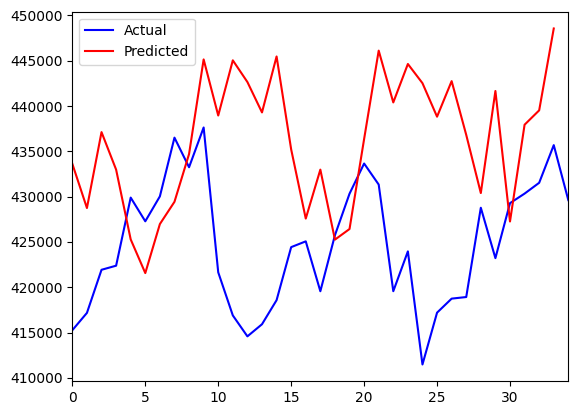

In [89]:
# Actual graph
actual_data = minmax.inverse_transform(np.concatenate((train_x_tensor_final.view(-1, input_size).cpu().numpy(), train_y_tensor_final.view(-1, 1).cpu().numpy()), axis=1))
mean_actual = actual_data.mean(axis=1)

plt.plot(mean_actual, label='Actual', color='blue')

# Predicted graph
predicted_data = minmax.inverse_transform(np.concatenate((test_x_tensor_final.view(-1, input_size).cpu().numpy(), test_outputs.view(-1, 1).cpu().numpy()), axis=1))
mean_predicted = predicted_data.mean(axis=1)

plt.plot(mean_predicted, label='Predicted', color='red')
plt.xlim(0, len(mean_predicted))

plt.legend()
plt.show()

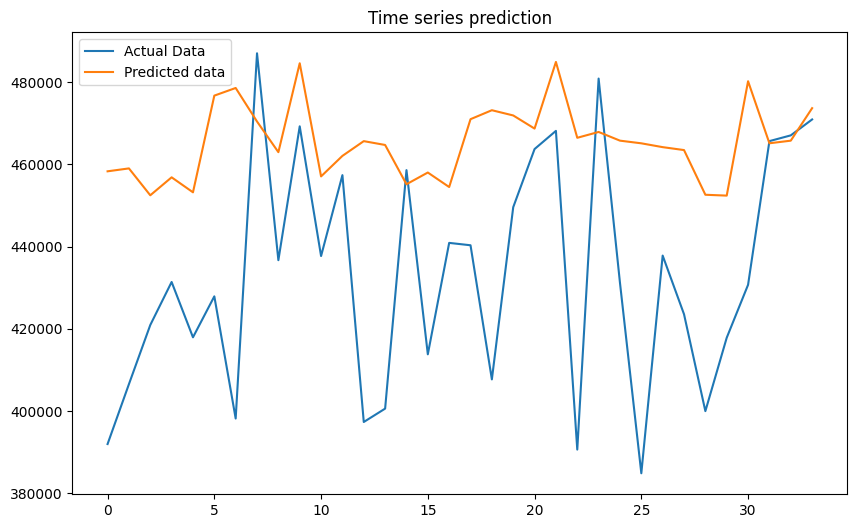

In [90]:
#Figure
plt.figure(figsize = (10,6)) # Plotting
plt.plot(actual, label = 'Actual Data')
plt.plot(predicted, label = 'Predicted data')
plt.title('Time series prediction')
plt.legend()
plt.show()